## This draft contains reading of database properly

In [91]:
%matplotlib inline

In [98]:
import re

from os import walk
from os.path import join

import numpy as np

from skimage.io import imread, imshow, show

In [77]:
# Read classes from file
labels = np.genfromtxt('../classes.csv', delimiter=',', dtype=str)
# because of space after comma we read redundant empty column
labels = np.array([l[0] for l in labels])

In [78]:
data_path = "../database/"
files = list()
for (dirpath, dirnames, filenames) in walk(data_path):
    files = filenames    

In [79]:
data_images = list()
data_labels = list()
label_from_name = r"([a-zA-z]+)[-_]\d+.pgm"

In [82]:
# here we load all the images and find their label from filename
for f in files:
    match = re.match(label_from_name, f)
    if match:
        label = match.groups()[0]
        if label in labels:
            data_labels.append(label)
            data_images.append(imread(join(data_path, f), as_grey=True))      
    else: 
        # if name does not match our regexp or label is not in the list
        # of classes - not read from database
        continue 

In [88]:
im = data_images[0]

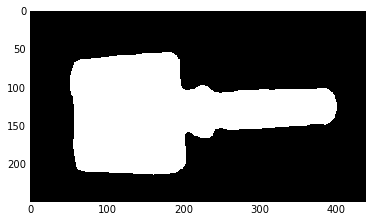

In [92]:
imshow(im)
show()

In [101]:
def indexing(data):
    """This function vectorizes the images with our implemented indexing method."""
#   here we can include contour finding
#   and all other things we do to find img description
#   should return np.appay that is of the same size (?) for all images
#   and each row represents image features
#   so later we can just pass it to the classifier 
    pass

In [110]:
# Later we would do:

In [106]:
# X = indexing(data_images)
# y = np.array(data_labels)

In [109]:
# clf = OneVsRestClassifier(GaussianNB())
# clf.fit(X, y)